In [1]:
# !pip install -U petrolib

In [2]:
#load packages
import pandas as pd
from pathlib import Path
from warnings import filterwarnings
from matplotlib import pyplot as plt
filterwarnings('ignore')

import petrolib

from petrolib.file_reader import load_las
from petrolib.procs import process_data, set_alias, trim, model_facies
from petrolib.stats import displayFreq, Correlation
from petrolib.interp import crossPlot, picketPlot
from petrolib.plots import *
from petrolib.workflow import Quanti

In [3]:
#checks the version of package
petrolib.__version__

'1.2.6'

In [4]:
path = Path('./')
#gets all LaS files in directory 
from glob import glob
paths = sorted(glob('*.las'))

wells = list()
for well in paths:
    df, _ = load_las(str('./')+well, return_csv=True, curves=['GR', 'ILD', 'RHOB', 'NPHI'])
    wells.append(set_alias(df.reset_index(), 'DEPT:1', 'GR', 'ILD', 'NPHI', 'RHOB'))

well10 = wells

In [5]:
df

,GR,ILD,RHOB,NPHI
DEPT:1,,,,
1080.2112,NaN,NaN,NaN,NaN
1080.3636,NaN,NaN,NaN,NaN
1080.5160,NaN,NaN,NaN,NaN
1080.6684,NaN,NaN,NaN,NaN
1080.8208,NaN,NaN,NaN,NaN
...,...,...,...,...
4335.0180,54.9375,0.0806,NaN,NaN
4335.1704,54.9375,0.0806,NaN,NaN
4335.3228,54.9375,0.0806,NaN,NaN


In [6]:
df.rename(columns={"ILD": "RT"}, inplace=True)

In [7]:
#processing the data of arbitrary valuesa
df = process_data(df, 'GR', 'RT', 'NPHI', 'RHOB')

df.describe()

,GR,RT,RHOB,NPHI
count,12108.000000,3773.000000,11994.000000,11131.000000
mean,65.141053,39.685892,2.294954,0.448706
std,27.784838,160.188059,0.105071,0.027832
min,0.000000,0.200000,2.001182,-0.150000
25%,38.388225,2.675000,2.214700,0.450000
50%,70.623798,3.931000,2.290500,0.450000
75%,89.452353,6.556900,2.375900,0.450000
max,142.546906,2000.000000,2.614600,0.450000


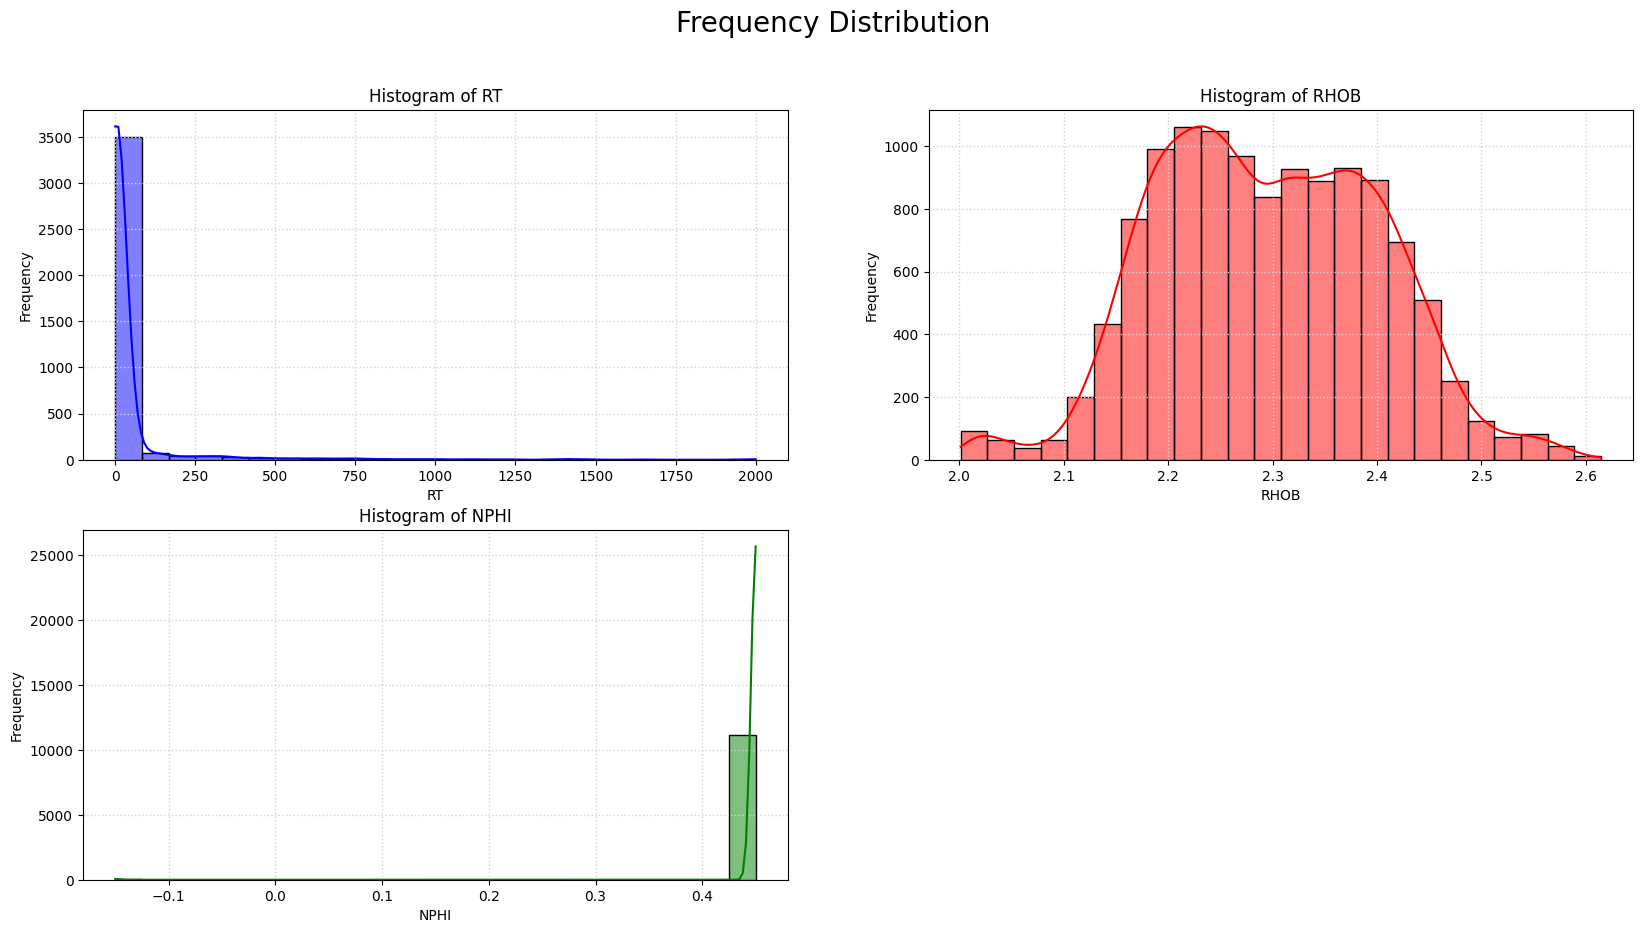

In [8]:
displayFreq(df, *(df.columns[1:]), figsize=(20, 10), bins=24)

In [9]:
#leverage on the correlation class to determine linear and non relationship between logs
# chatter jee helps to determine the non-linear relation
corr = Correlation(df)
chatterjee = corr.corr(method='chatterjee')
chatterjee

,GR,RT,RHOB,NPHI
GR,0.999921,0.914303,0.753198,0.933603
RT,0.988988,0.999976,0.988950,0.995472
RHOB,0.762479,0.911962,0.999921,0.923744
NPHI,0.999780,1.000000,0.998536,0.999963


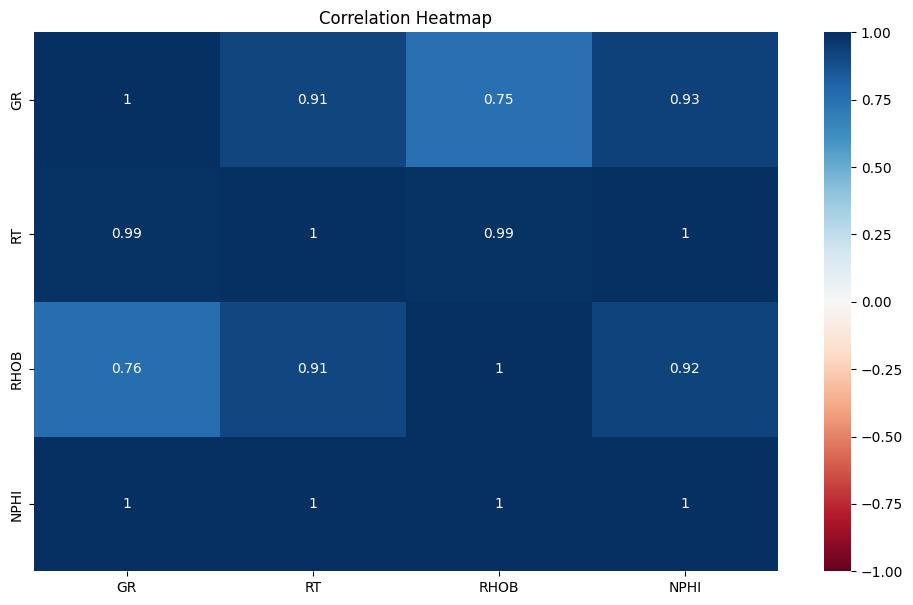

In [10]:
corr.plot_heatmap(cmap='RdBu')

In [11]:
df = model_facies(df, 'GR', env='SS')

df

,GR,RT,RHOB,NPHI,litho
DEPT:1,,,,,
1080.2112,NaN,NaN,NaN,NaN,Shale
1080.3636,NaN,NaN,NaN,NaN,Shale
1080.5160,NaN,NaN,NaN,NaN,Shale
1080.6684,NaN,NaN,NaN,NaN,Shale
1080.8208,NaN,NaN,NaN,NaN,Shale
...,...,...,...,...,...
4335.0180,54.9375,0.2,NaN,NaN,Sandstone
4335.1704,54.9375,0.2,NaN,NaN,Sandstone
4335.3228,54.9375,0.2,NaN,NaN,Sandstone


In [12]:
df_reset = df.reset_index()
df_reset.rename(columns={"DEPT:1": "depth"}, inplace=True)
df_reset

,depth,GR,RT,RHOB,NPHI,litho
0,1080.2112,NaN,NaN,NaN,NaN,Shale
1,1080.3636,NaN,NaN,NaN,NaN,Shale
2,1080.5160,NaN,NaN,NaN,NaN,Shale
3,1080.6684,NaN,NaN,NaN,NaN,Shale
4,1080.8208,NaN,NaN,NaN,NaN,Shale
...,...,...,...,...,...,...
21357,4335.0180,54.9375,0.2,NaN,NaN,Sandstone
21358,4335.1704,54.9375,0.2,NaN,NaN,Sandstone
21359,4335.3228,54.9375,0.2,NaN,NaN,Sandstone
21360,4335.4752,54.9375,0.2,NaN,NaN,Sandstone


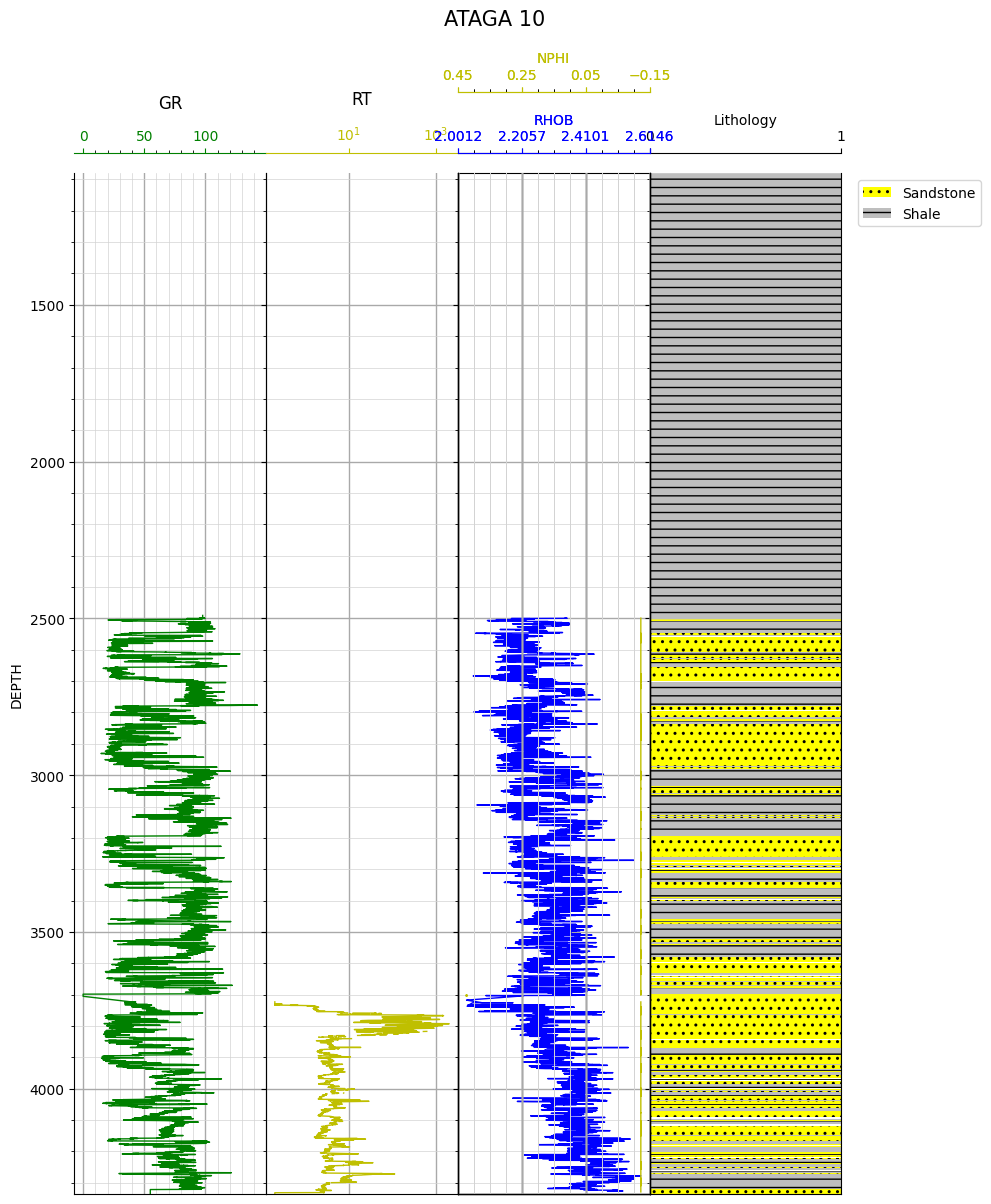

In [13]:
plotLogFacies(df_reset, 'depth', ['GR', 'RT', ['RHOB', 'NPHI']], top=df_reset['depth'].min(), facies='litho',
              bottom=df_reset['depth'].max(), figsize=(10, 12), title='ATAGA 10')


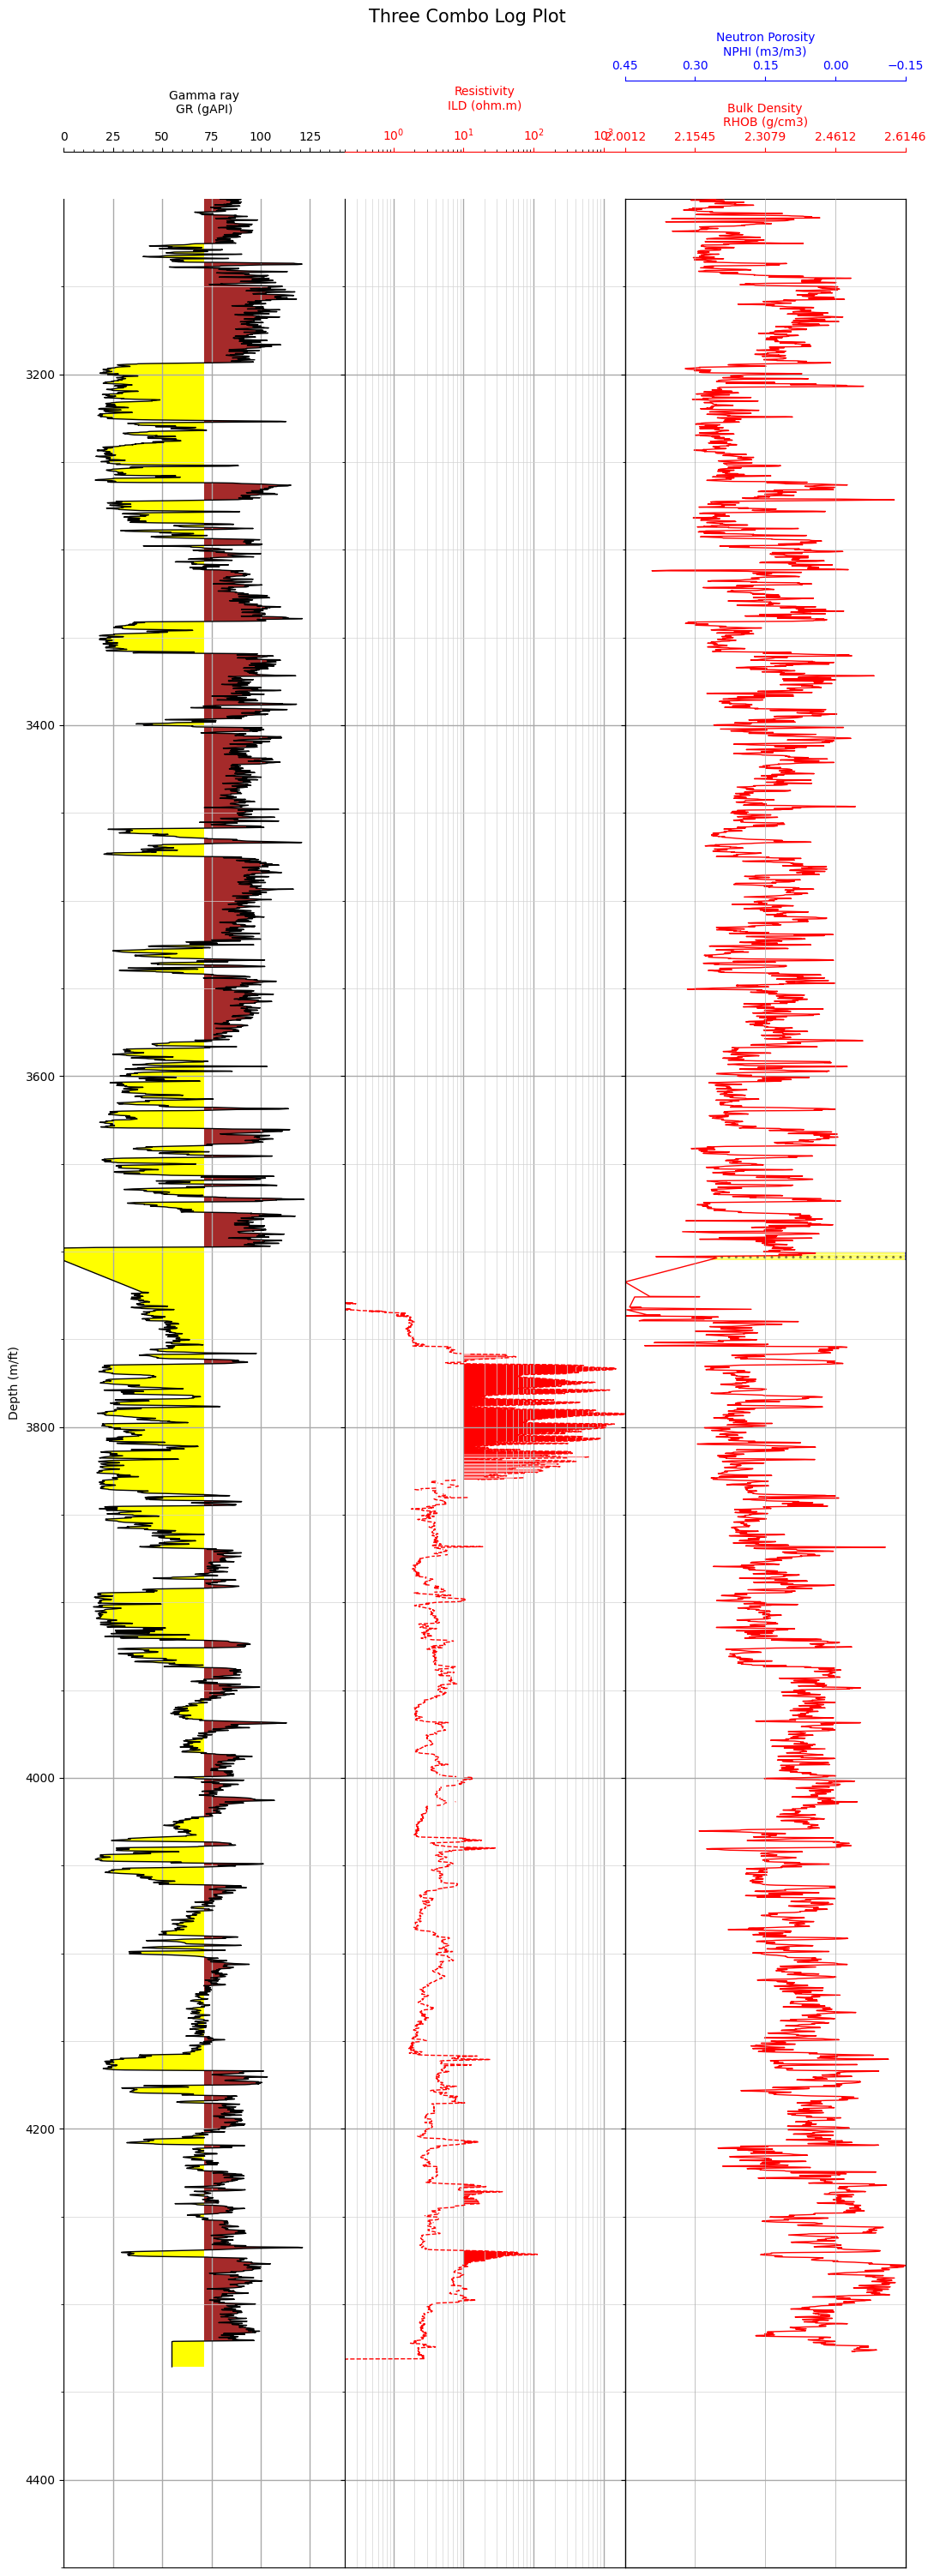

In [14]:
tripleCombo(df_reset, 'depth', 'GR', 'RT', 'NPHI', 'RHOB', 3100,  4450,
            res_thres=10, fill='left', figsize=(11, 30))

In [15]:
well11tops = Zonation(df_reset, path='ataga 11.csv')

well11tops

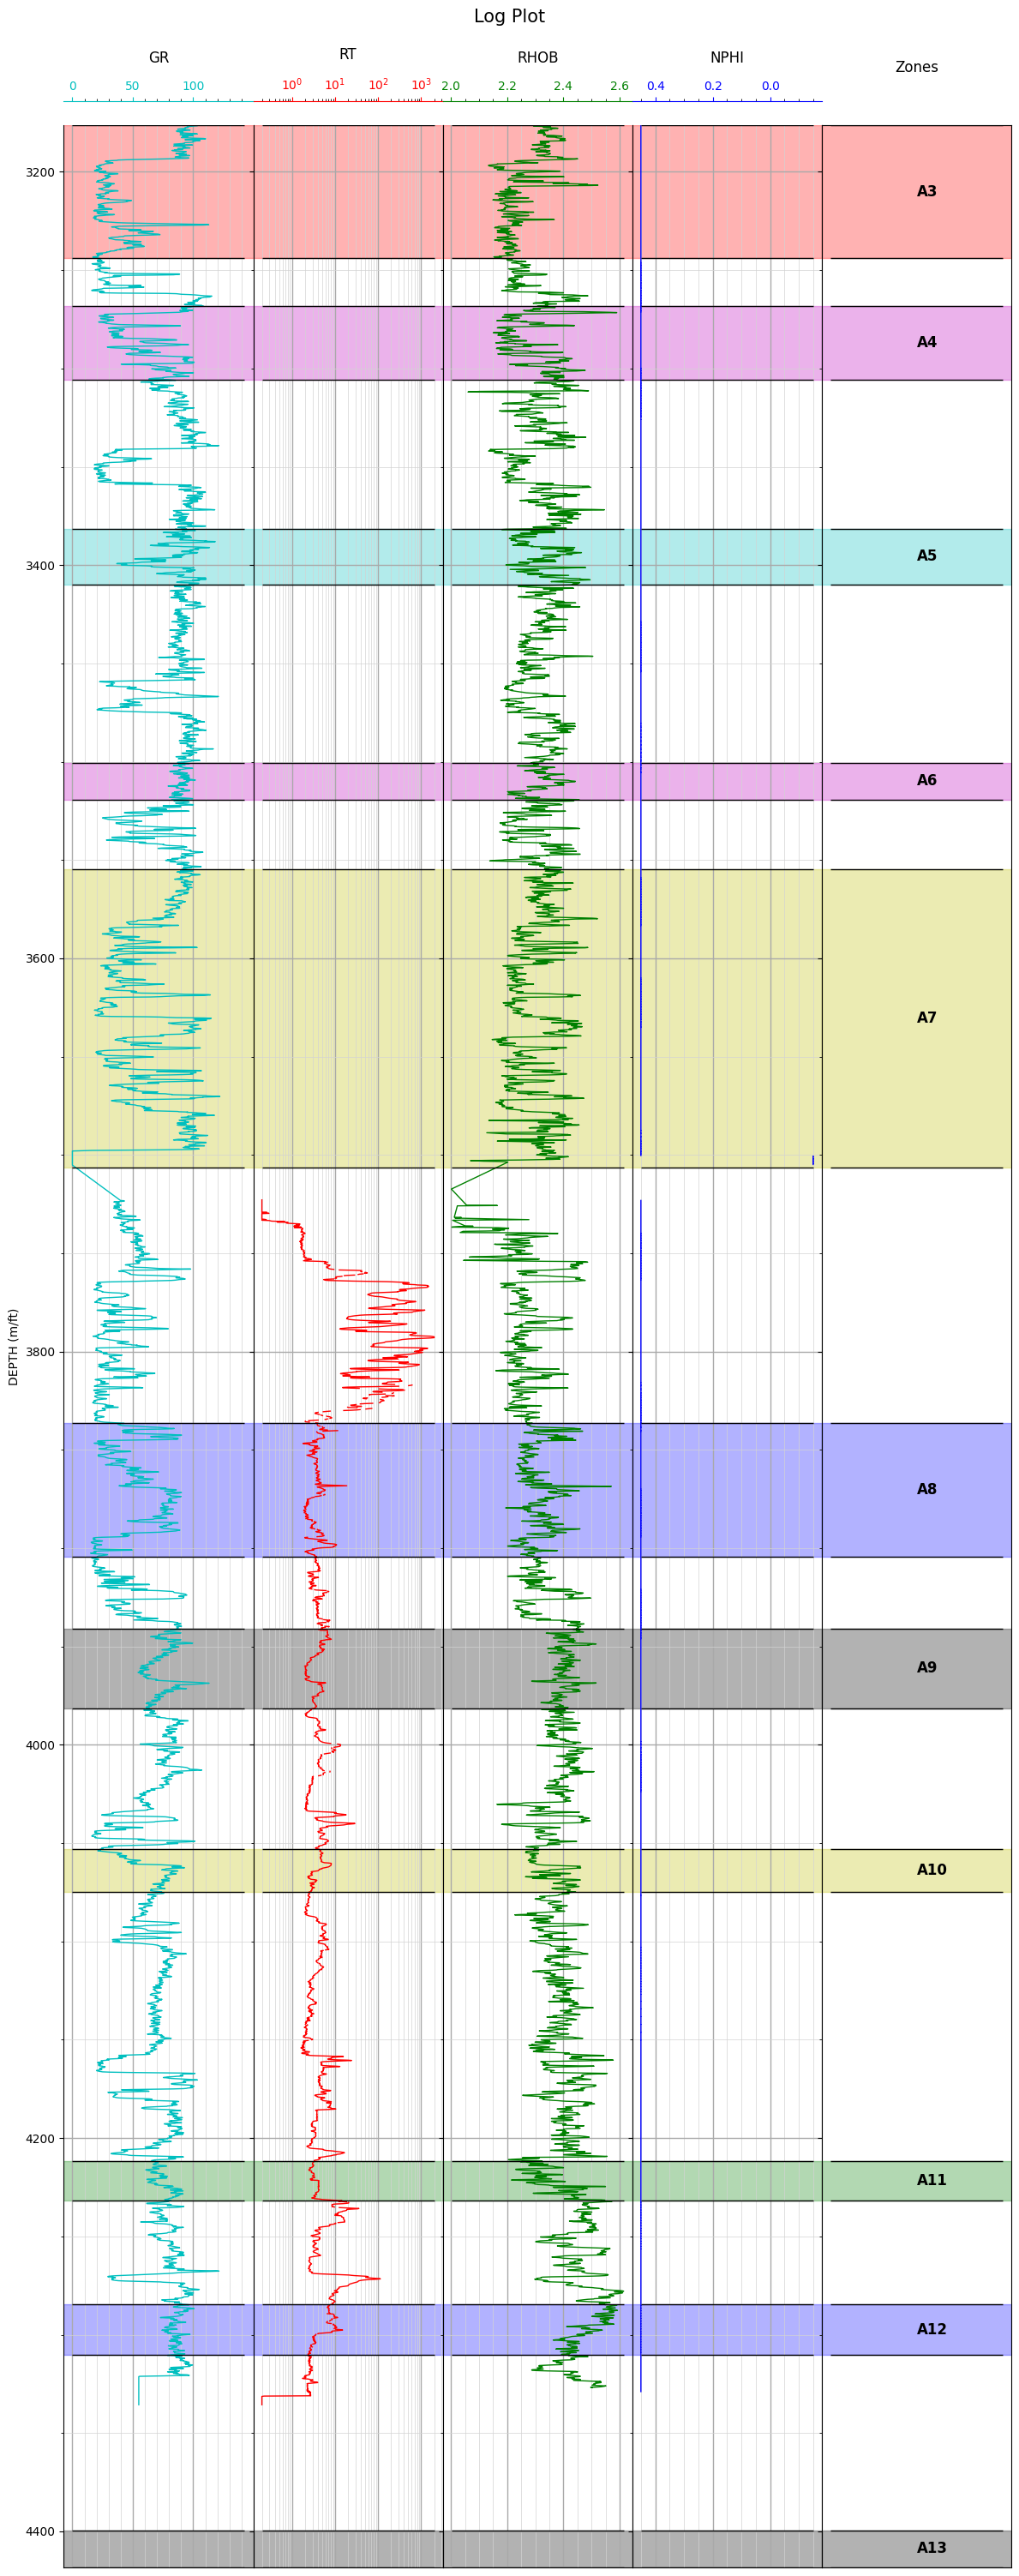

In [16]:
#extracts well information by calling the Zonation object
ztop, zbot, zn, fm = well11tops()

#plot the zone informations by calling the `plotZone` method
well11tops.plotZone('depth', ['GR', 'RT', 'RHOB', 'NPHI'], min(ztop), max(zbot), figsize=(12, 30))

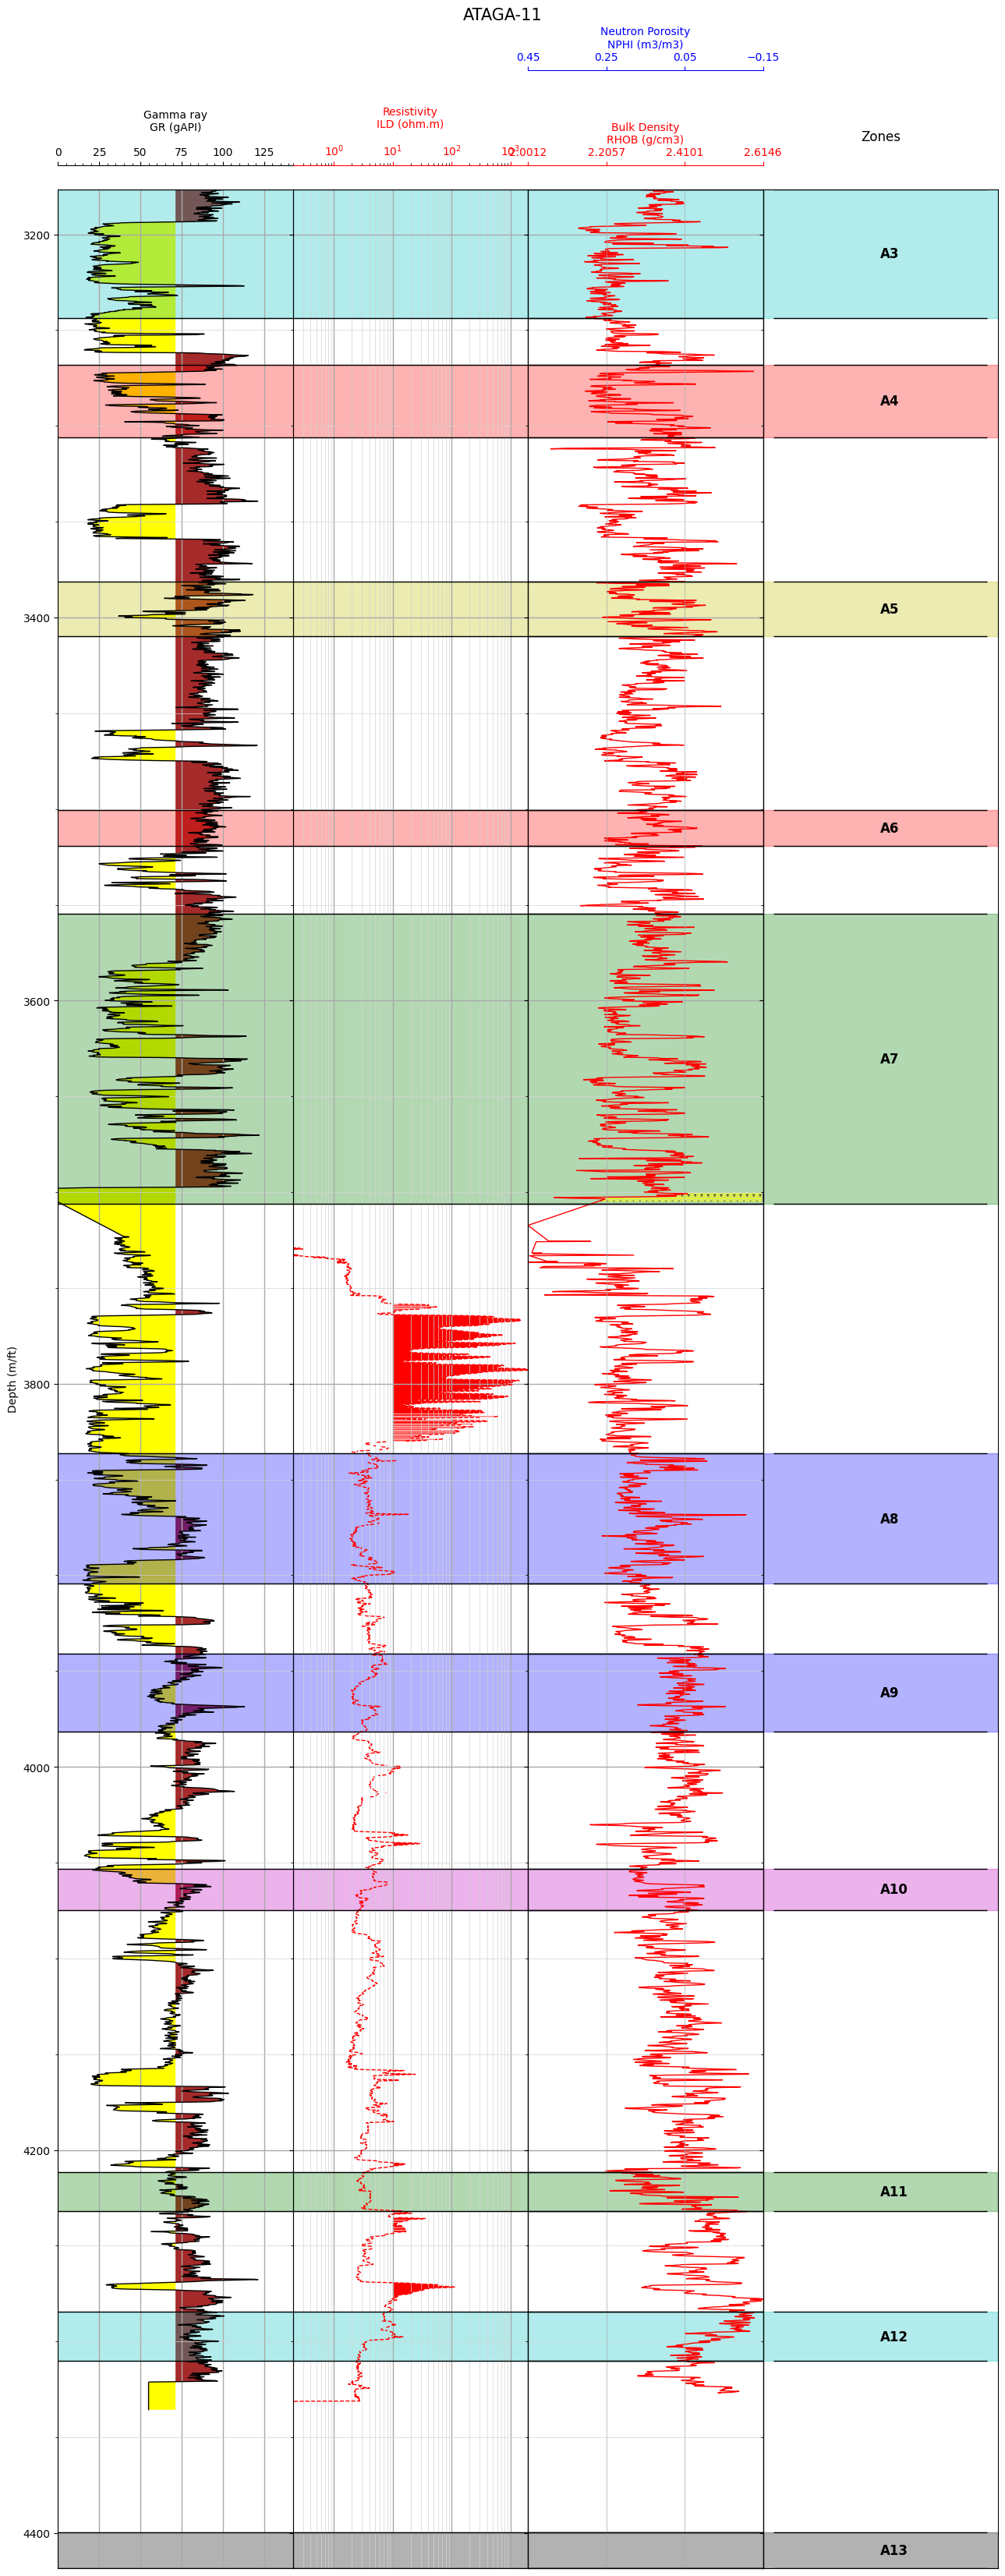

In [17]:
#plot three combo alongside the zone
plotZoneCombo(df_reset, 'depth', 'GR', 'RT', 'NPHI', 'RHOB', min(ztop), max(zbot),
               ztop, zbot, zn, fill='left', limit=None, figsize=(13, 33), title='ATAGA-11')

In [18]:
pp = Quanti(df_reset, zonename=zn[:2], ztop=ztop[:2], zbot=zbot[:2], f_mids=fm[:2], depth='depth', gr='GR', rt='RT', nphi='NPHI', rhob='RHOB')

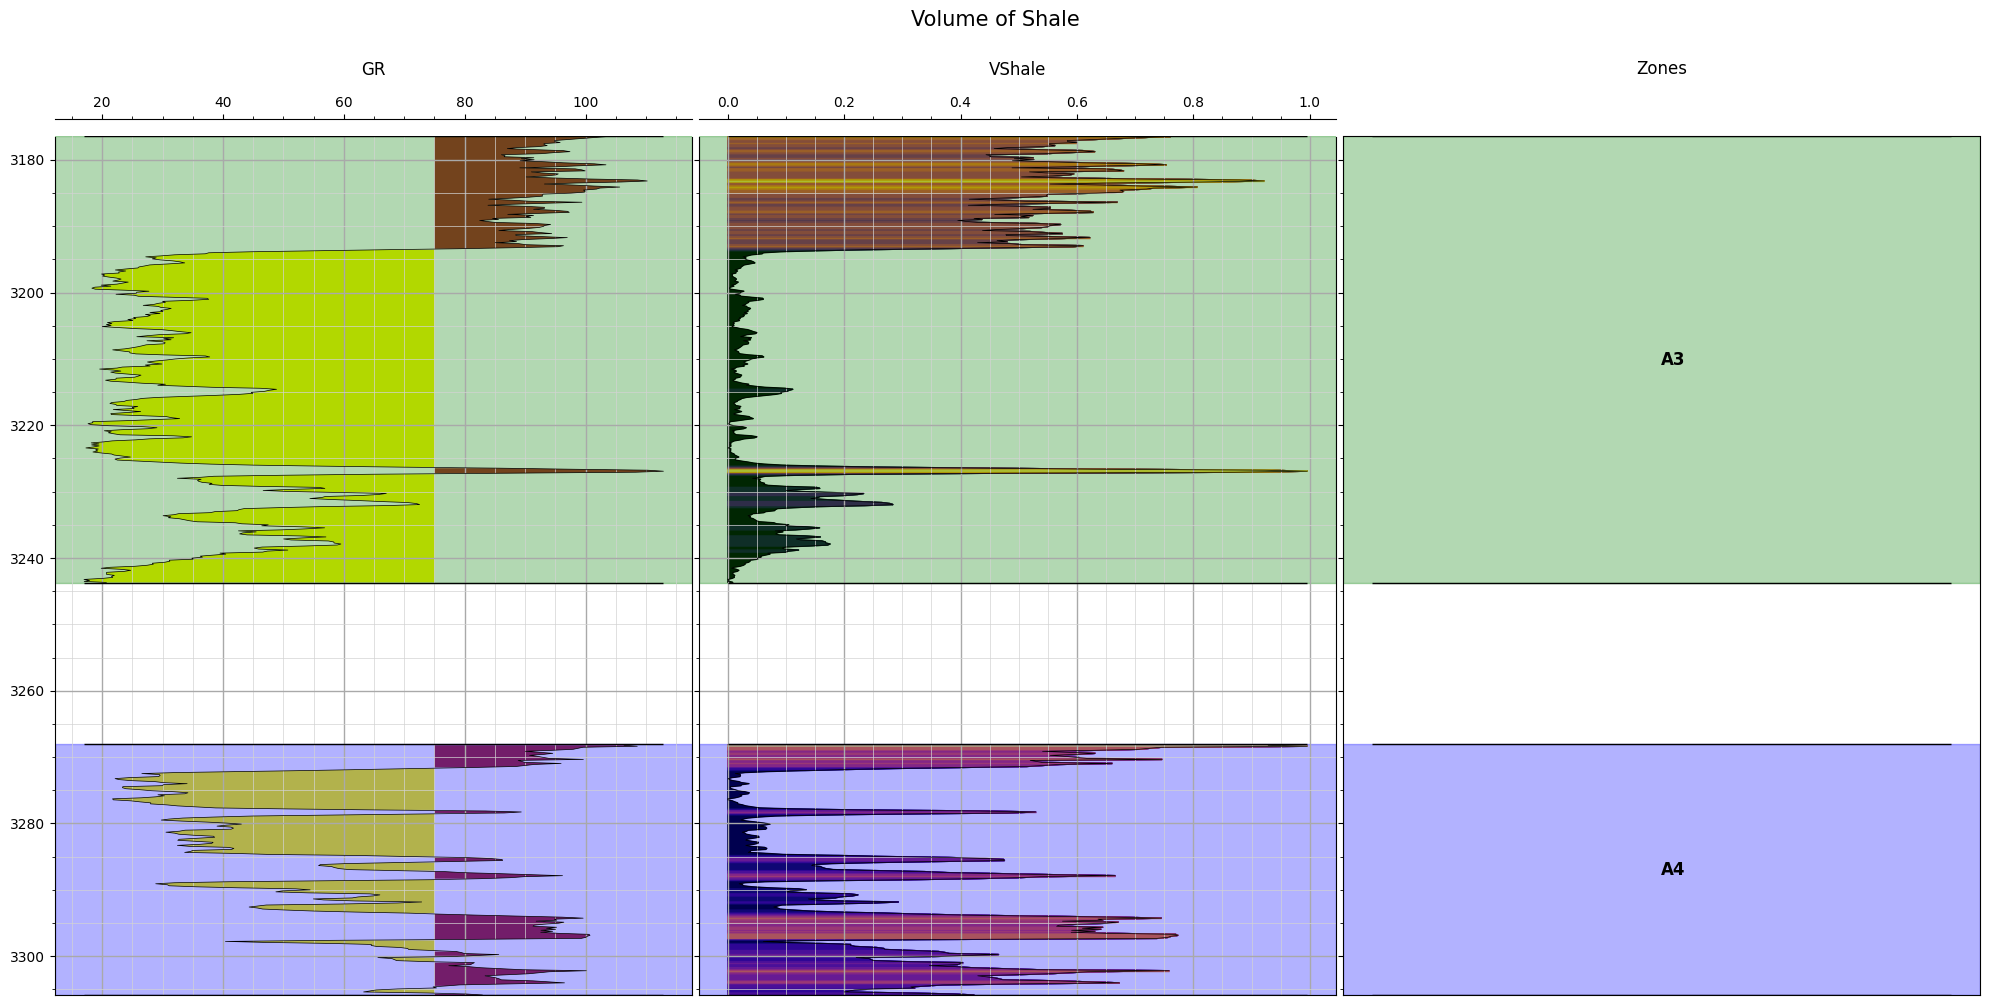

In [19]:
#various methods can be used to estimate the VSH, you can refer to documentation
#low VSH response is seen
vshale = pp.vshale(method='larionov_ter', show_plot=True, palette_op='inferno', figsize=(20, 10))

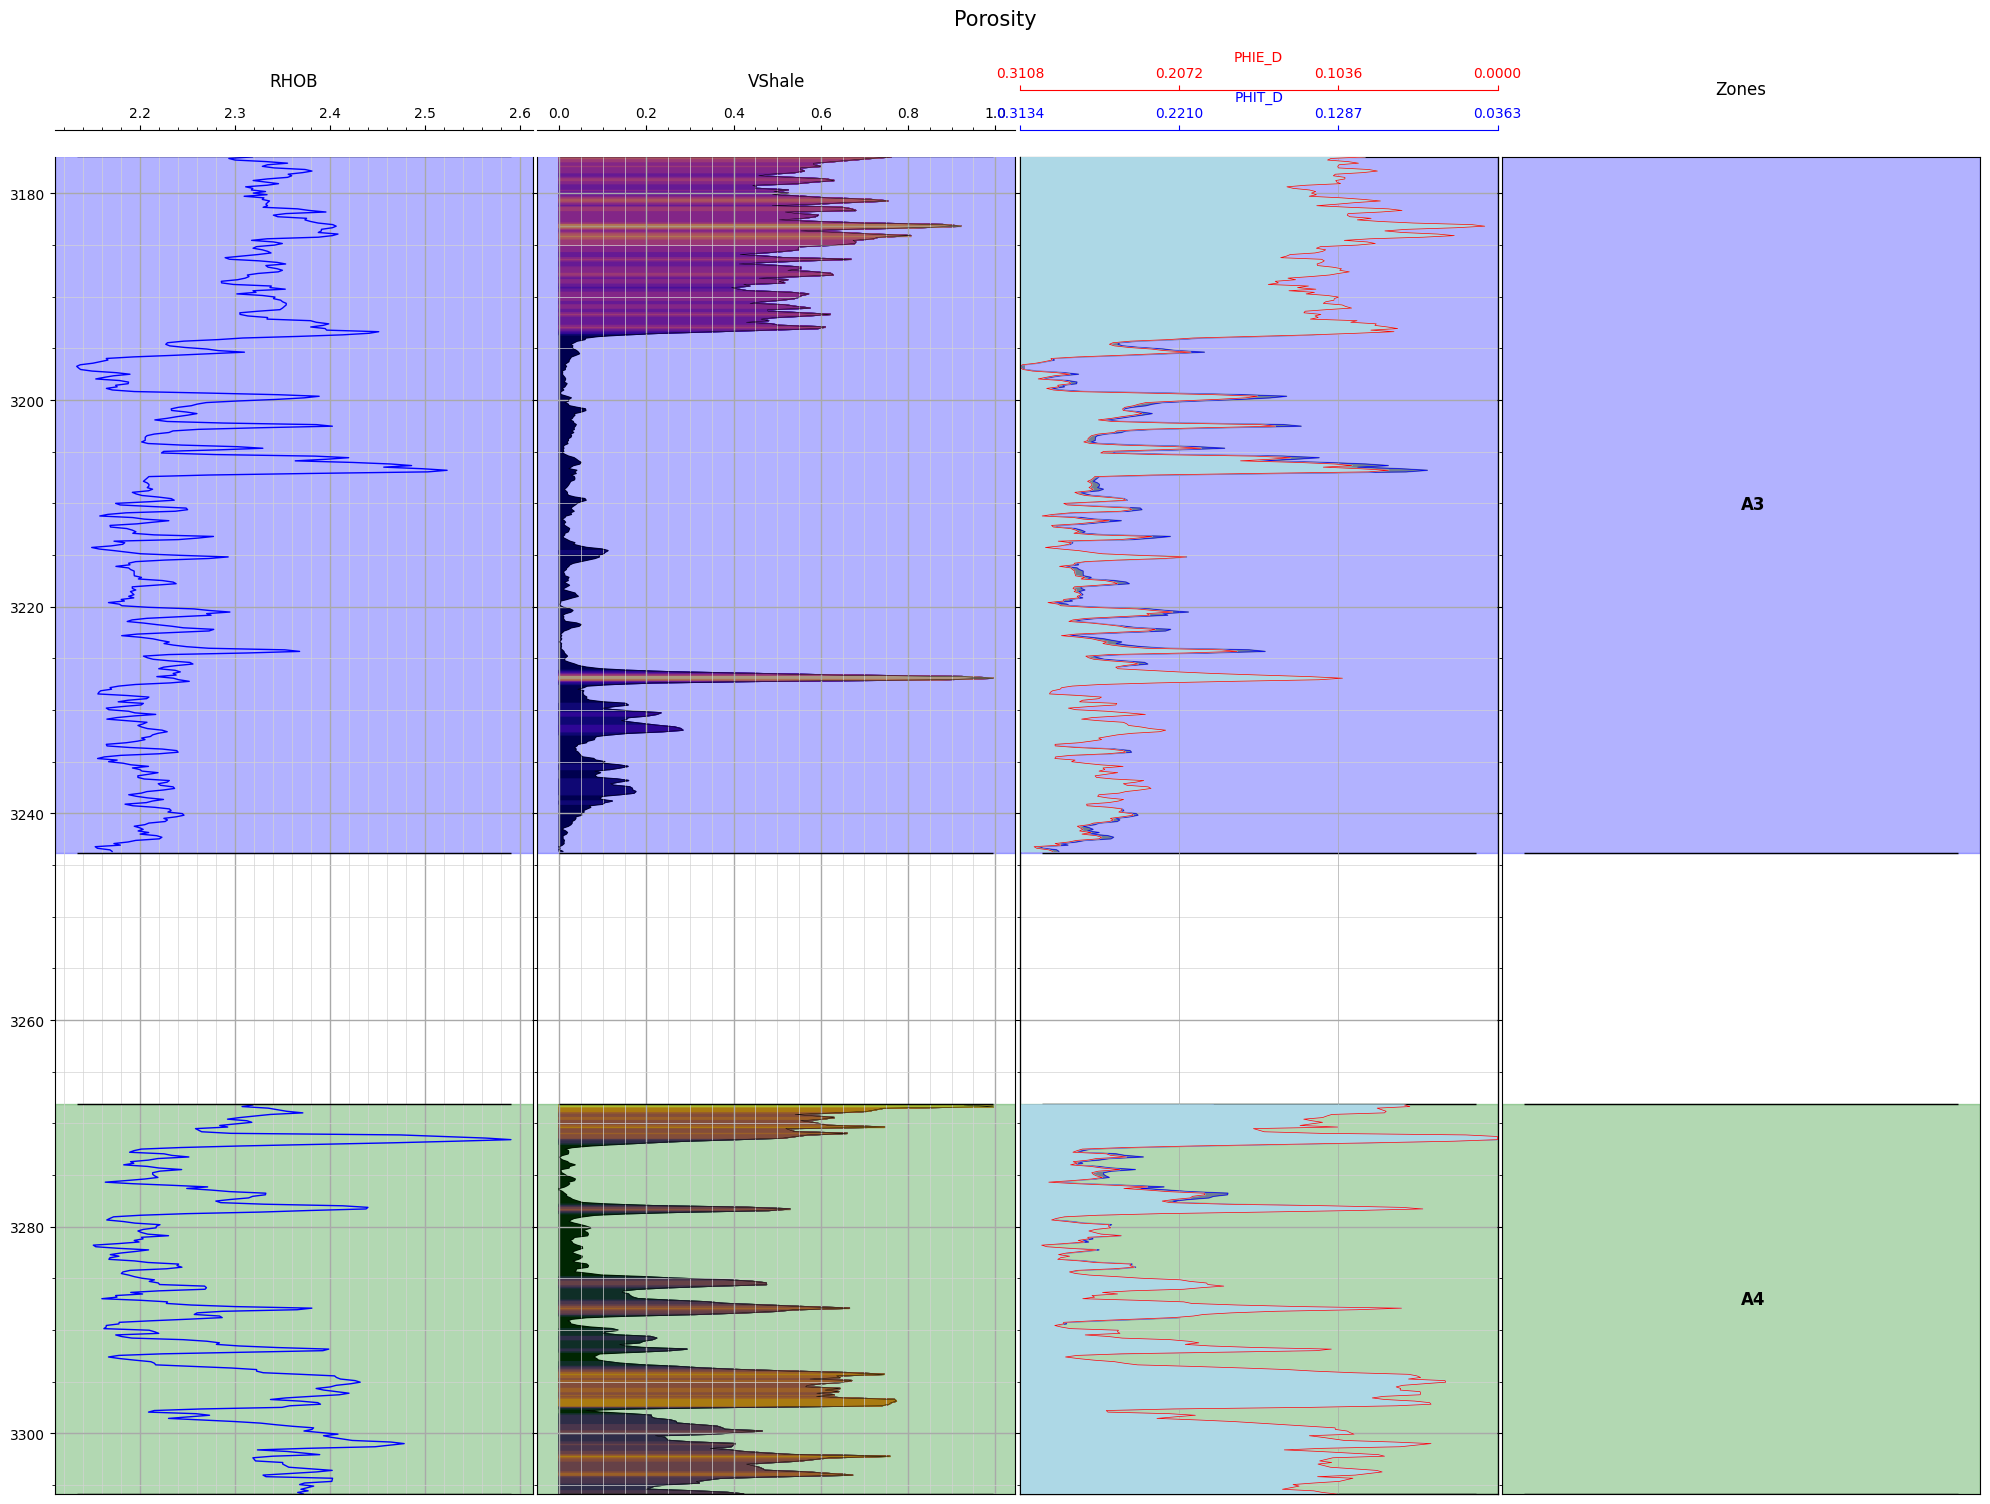

In [20]:
por = pp.porosity(method='density', show_plot=True, figsize=(20, 15))

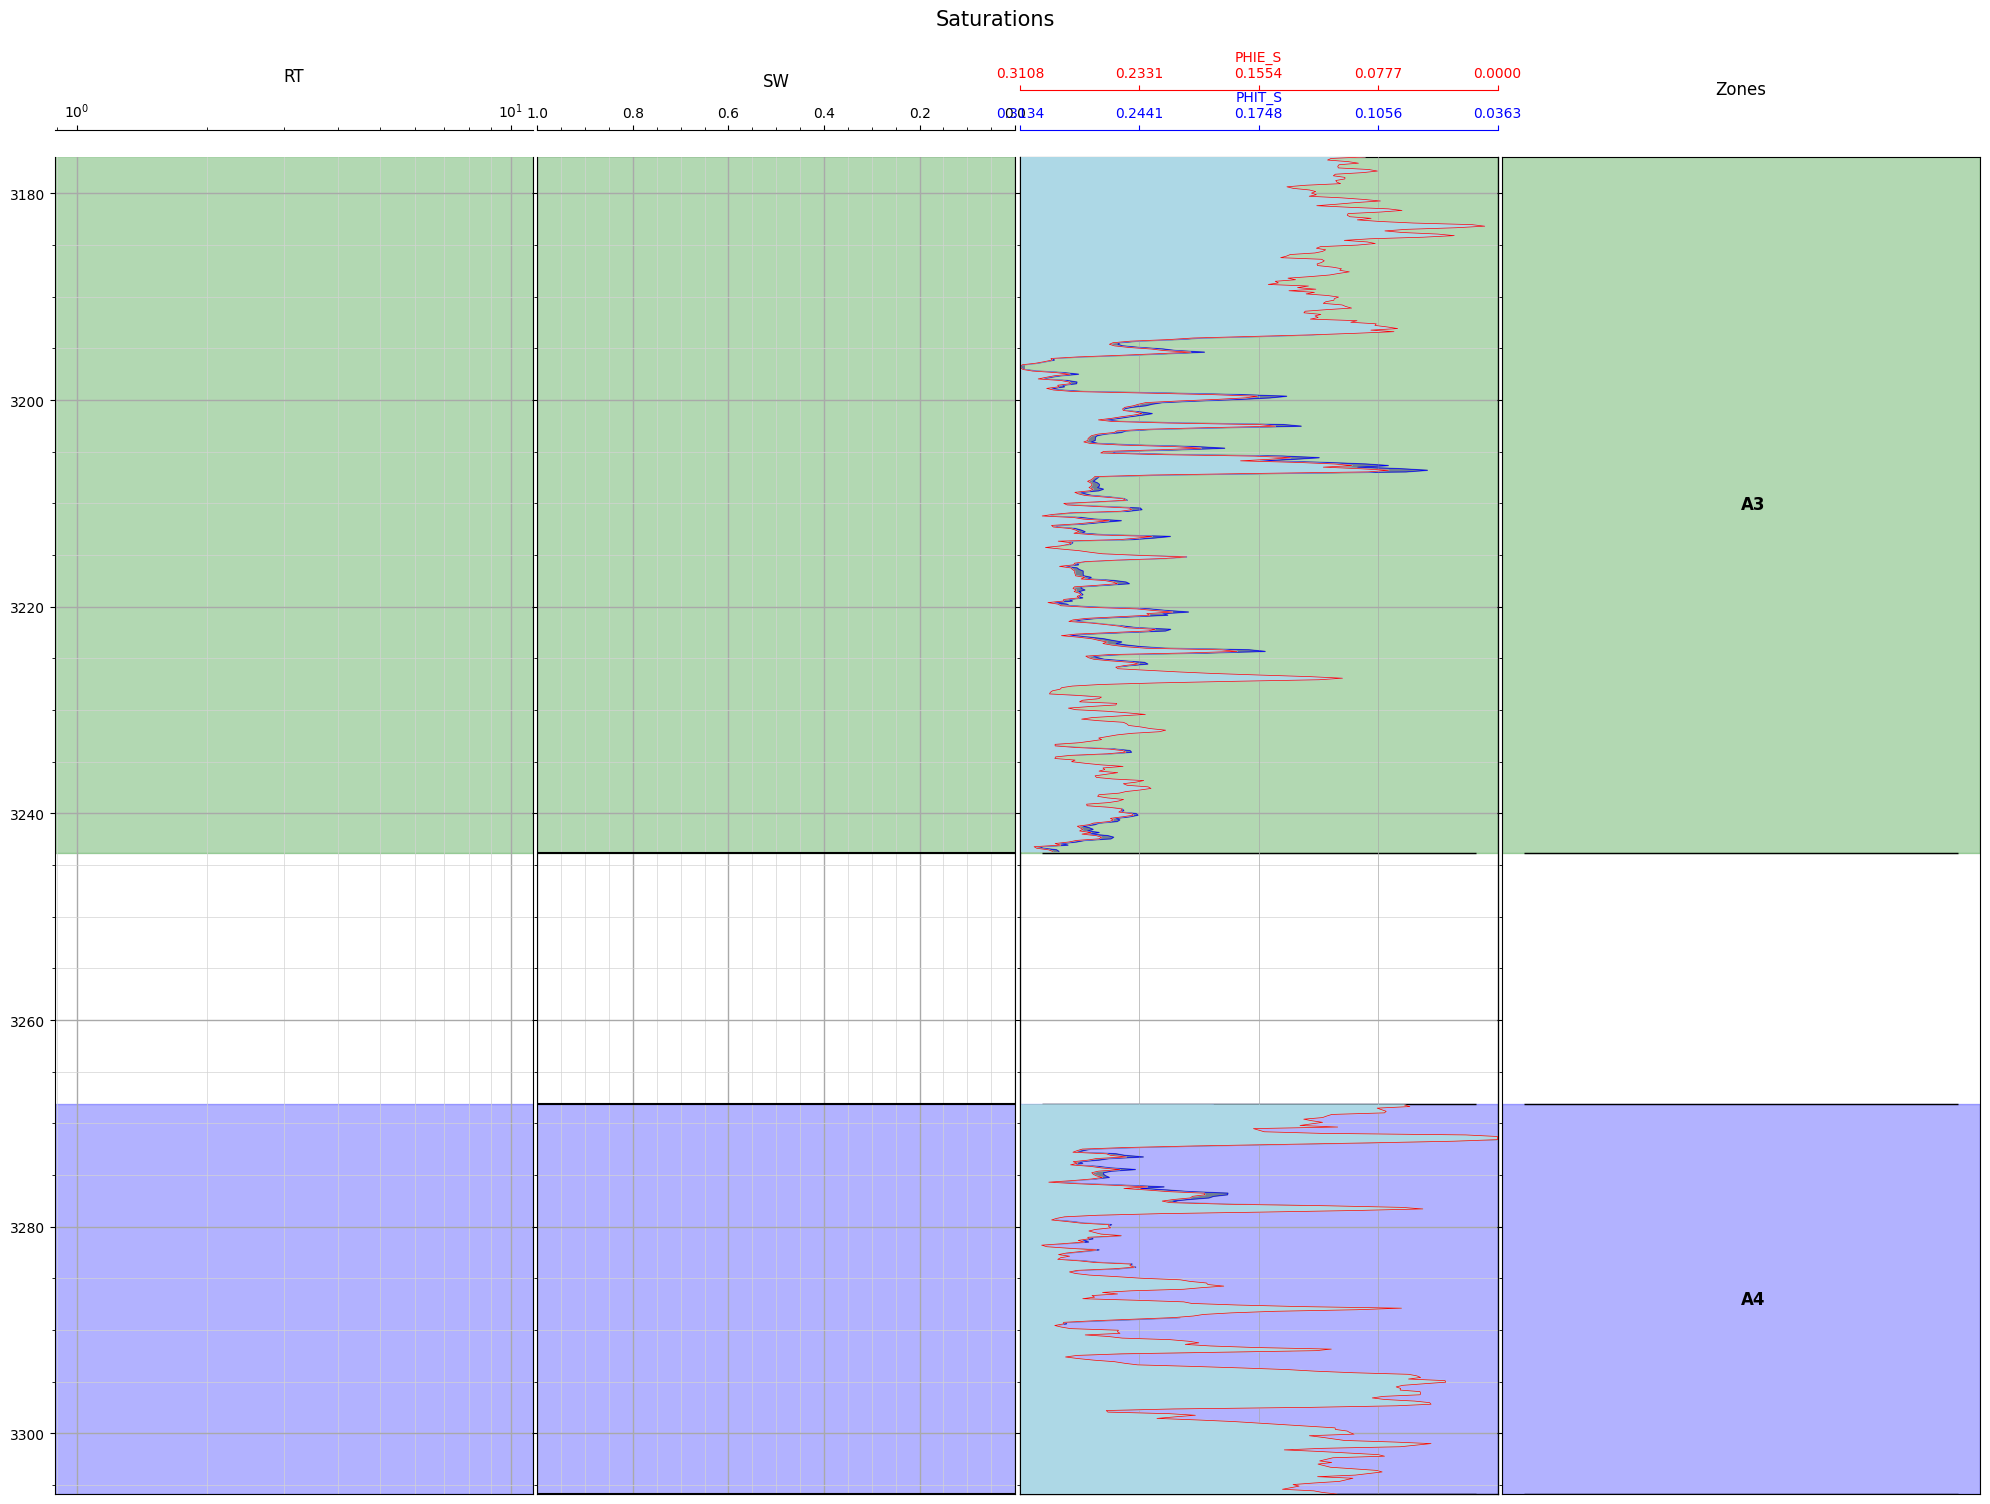

In [21]:
#water saturation
sat = pp.water_saturation(method='simmandoux', show_plot=True, figsize=(20, 15))

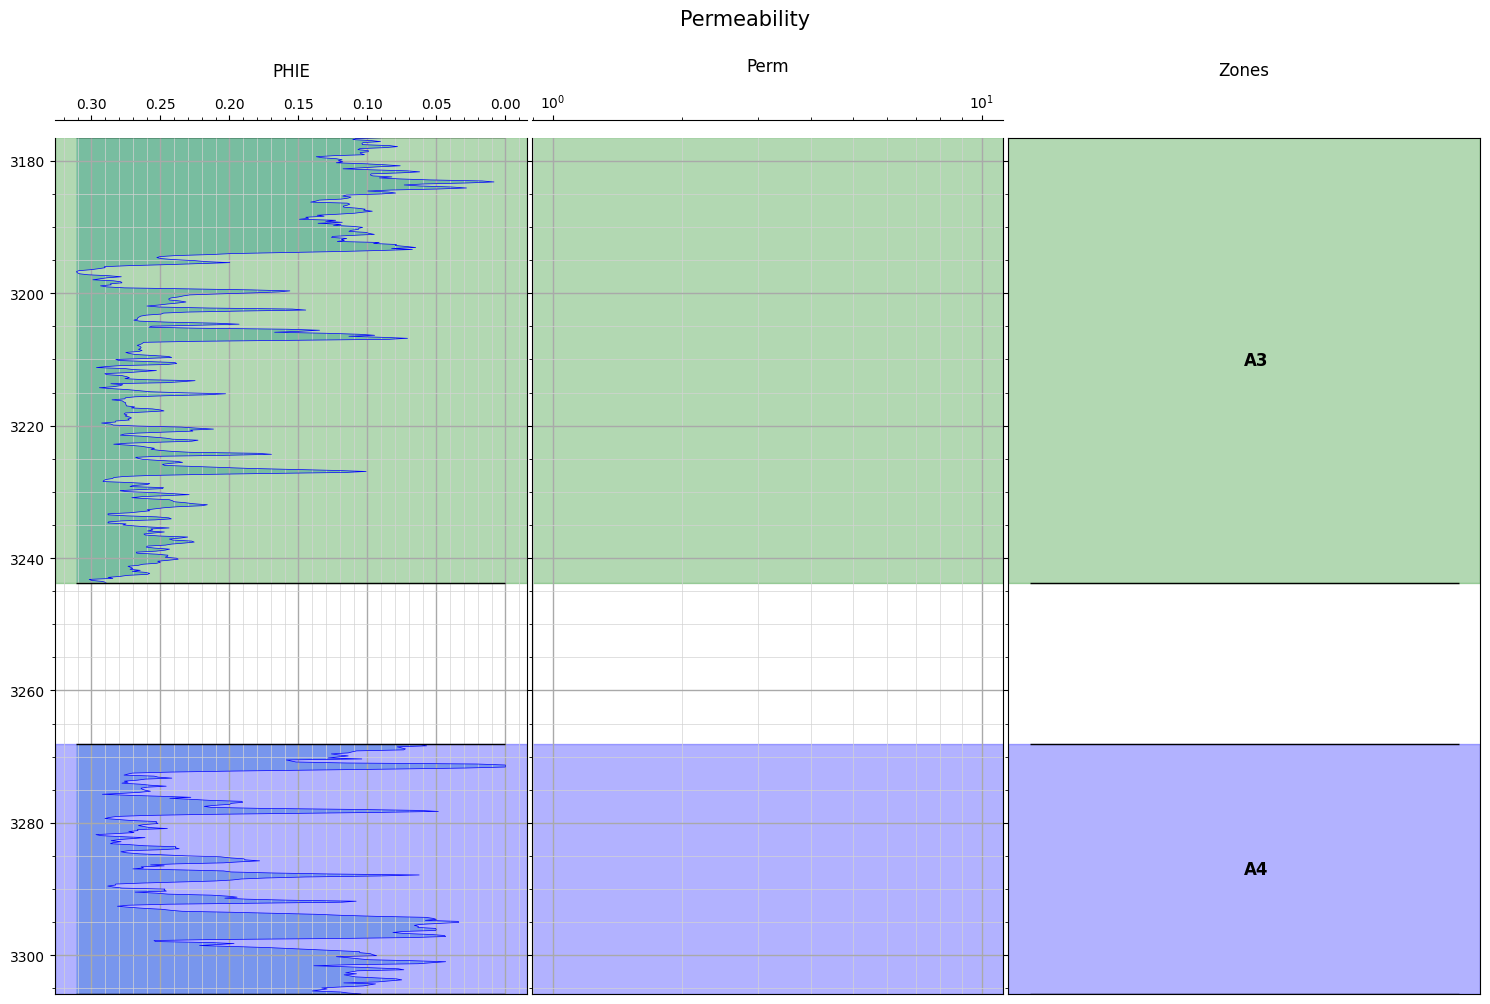

In [22]:
#permeability
plt.style.use('default')
perm = pp.permeability(show_plot=True, figsize=(15, 10))

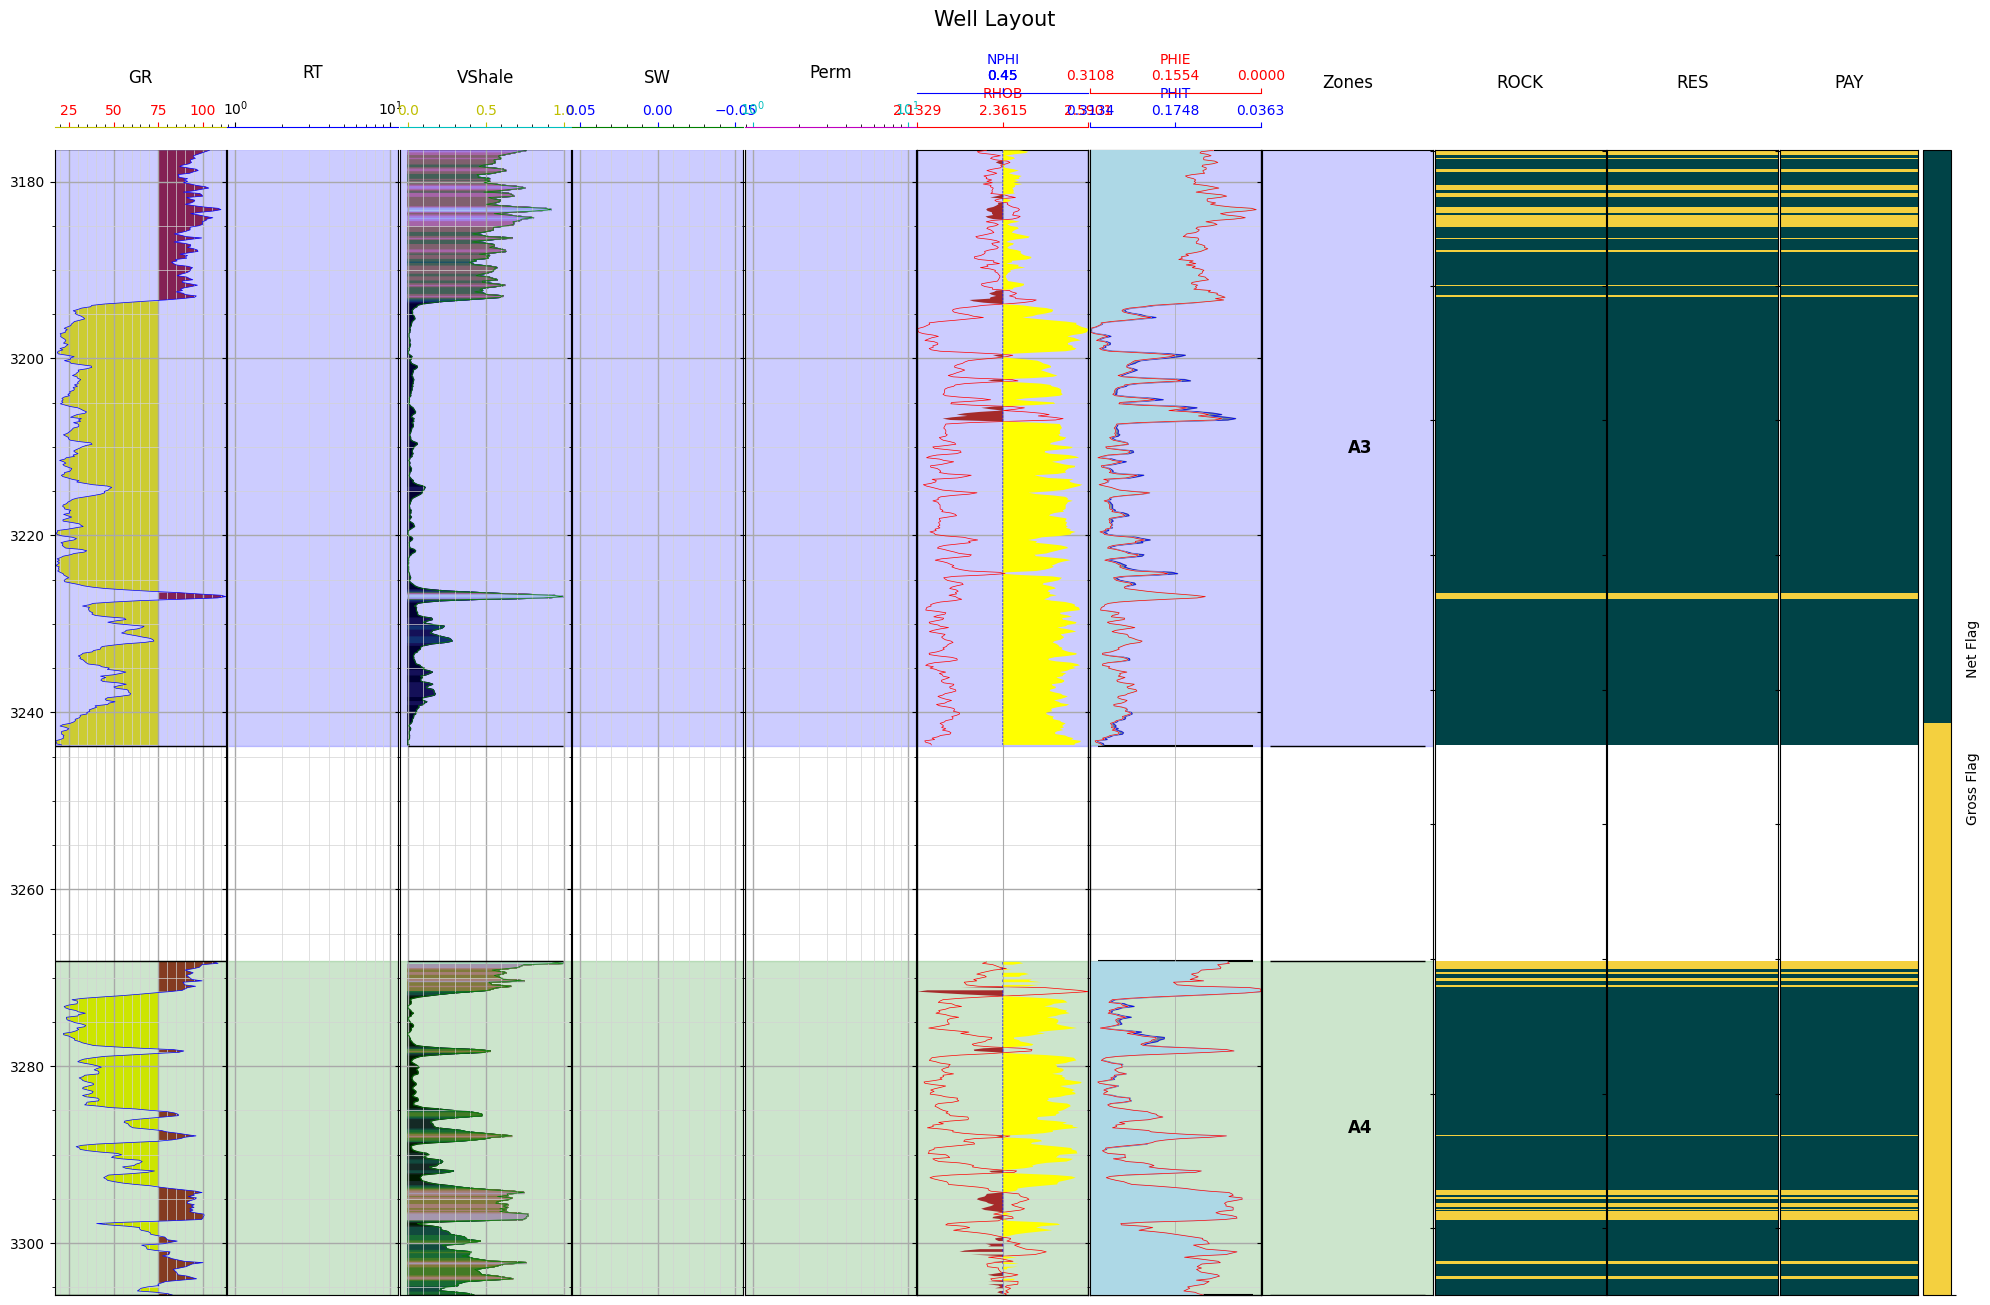

In [23]:
#applies VSH, SW and PHI cut-offs to flag payfrom non-pay regions
report = pp.flags(vsh_cutoff=.6, por_cutoff=.2, sw_cutoff=.8, show_plot=True, palette_op='cubehelix', figsize=(20, 13))

In [29]:
#displays pays summary results
table = pp.paySummary(name='ATG-10')
table

,Well,Zones,Flag Name,Top,Bottom,Unit,Gross,Net,Not Net,NTG,BVW,Average VShale,Average Porosity,Average Water Saturation
0,ATG-10,A3,ROCK,3176.473200,3243.681600,m,67.208400,47.593279,19.615121,0.708145,nan,0.044177,0.251421,nan
1,ATG-10,A3,RES,3176.473200,3243.681600,m,67.208400,47.593279,19.615121,0.708145,nan,0.044177,0.251421,nan
2,ATG-10,A3,PAY,3176.473200,3243.681600,m,67.208400,47.593279,19.615121,0.708145,nan,0.044177,0.251421,nan
3,ATG-10,A4,ROCK,3268.218000,3305.860800,m,37.642800,17.910687,19.732113,0.475806,nan,0.065839,0.250722,nan
4,ATG-10,A4,RES,3268.218000,3305.860800,m,37.642800,17.910687,19.732113,0.475806,nan,0.065839,0.250722,nan
5,ATG-10,A4,PAY,3268.218000,3305.860800,m,37.642800,17.910687,19.732113,0.475806,nan,0.065839,0.250722,nan


In [31]:
#ave pay summary result to excel file in the working directory
pp.save('ATG-10')

In [32]:
#displays report of methods and cutoffs used
pp.report()

,
PHI Cutoff,0.600000
Porosity,Density
SH Cutoff,0.800000
VSH Cutoff,0.200000
VShale,Larionov_Ter
Water Saturation,Simmandoux


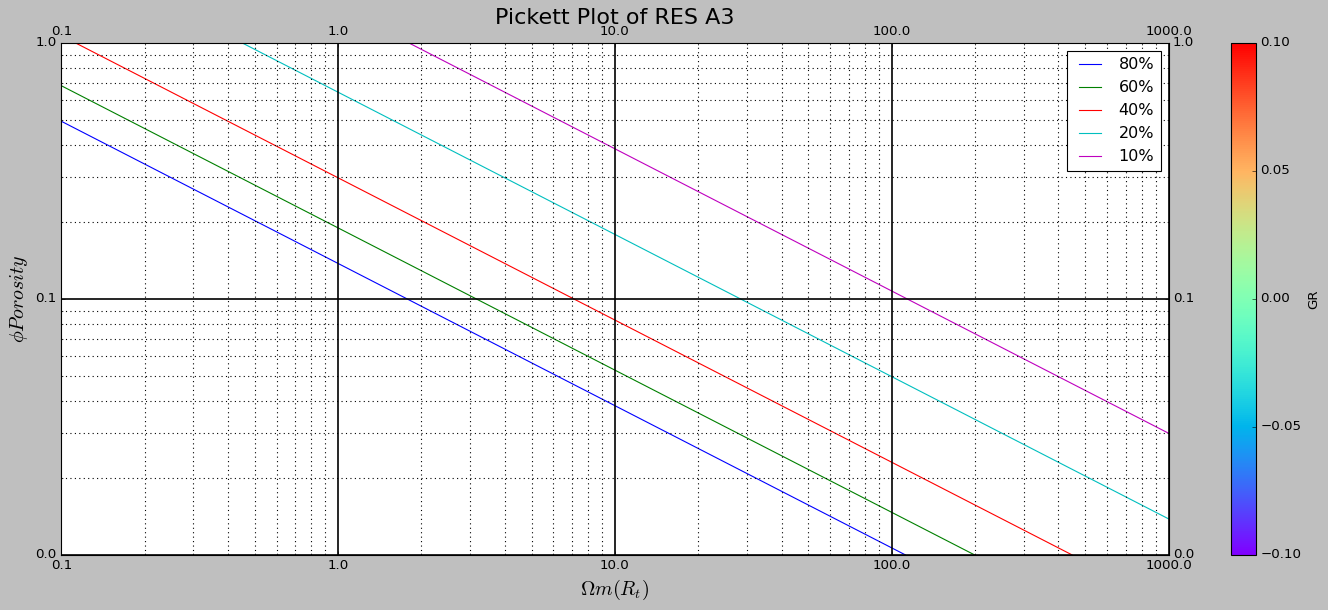

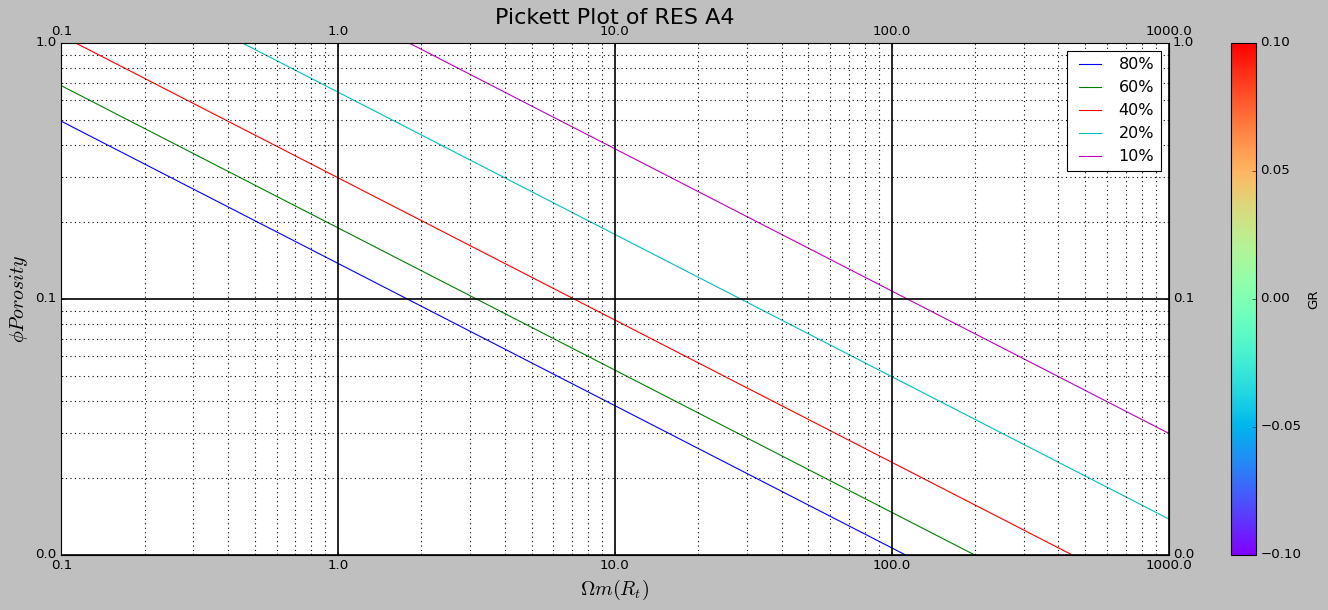

In [33]:
# from petrolib.interp import picketPlot, crossPlot

#Picket Plot for the first two reservoirs

for i, zone in enumerate(zn[:2]):
    plt.style.use('classic') 
    res = por[i]
    picketPlot(res, color_code='num', hue='GR', cmap='rainbow', res_name=zone)

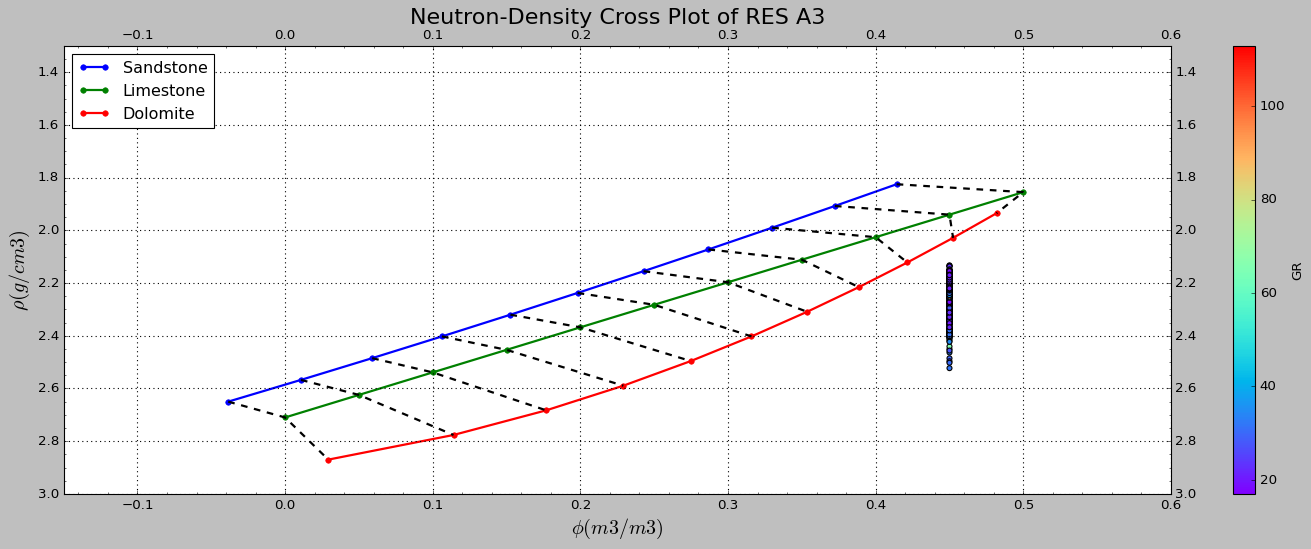

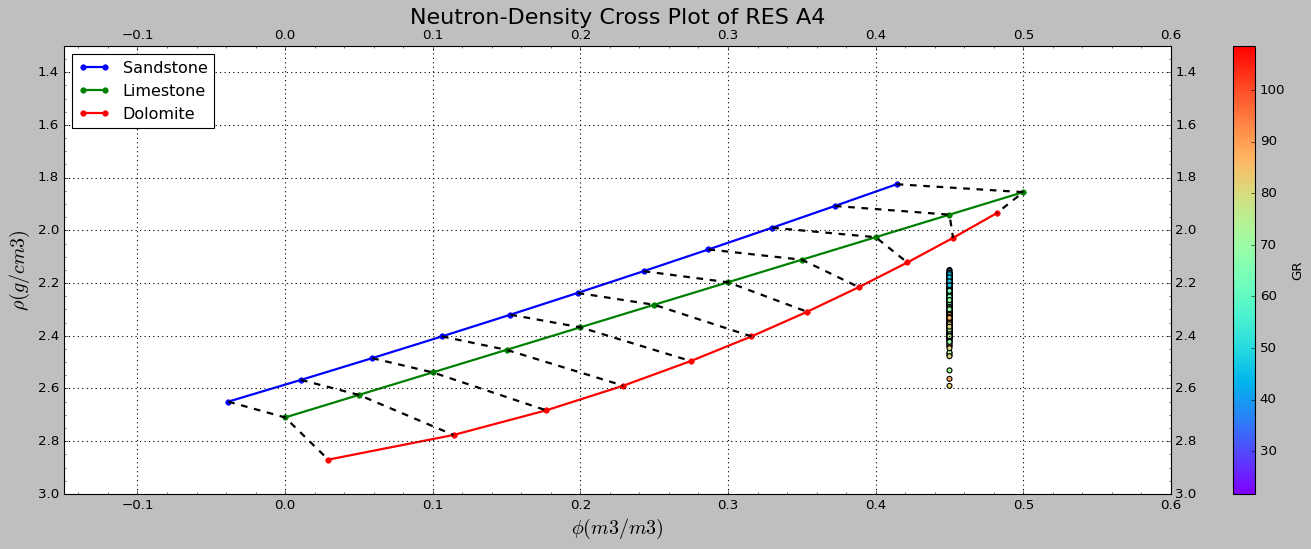

In [34]:
#Crossplot

for i, zone in enumerate(zn[:2]):
    plt.style.use('classic')
    res = por[i]
    crossPlot(res, 'NPHI', 'RHOB', color_code='num', hue='GR', cmap='rainbow', res_name=zone)